Adrian Kraugh-Hillers (s201390)

August Birch (s204129)

Bjarke Erichsen (s204104)


Contributions.    
We have contributed equally to all parts of the rapport!

Part 1 Main responsible = August Birch     
Part 2 Main responsible = Adrian Kraugh-Hillers     
Part 3 Main responsible = Bjarke Erichsen    

Github
https://github.com/BjarkeErichsen/SocialEngineering

In [1]:
#Remember to pip install the huggingface model before running the code
!pip install https://huggingface.co/spacy/en_core_web_sm/resolve/main/en_core_web_sm-any-py3-none-any.whl

     --------------------------------------- 12.8/12.8 MB 23.4 MB/s eta 0:00:00


You should consider upgrading via the 'c:\users\eg\anaconda3\python.exe -m pip install --upgrade pip' command.


In [7]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import numpy as np
import time 
import matplotlib.pyplot as plt
from transformers import pipeline
import en_core_web_sm 
import matplotlib as mpl

# Part 1

In [3]:
"""
Here we webscrape from 2019 posters.
This is done in a regular manner using BeutifulSoup.
The participants is collected in the "participants_POSTERLINK_text_2019" list. 
"""

Link2019Posters = "https://2019.ic2s2.org/posters/"
LINK = Link2019Posters
r = requests.get(LINK)
soup2019 = BeautifulSoup(r.content)
soupLI = soup2019.find_all('li')
participants_POSTERLINK_text_2019 = []
for i in range(32, len(soupLI)):      #We choose 32, because it is only the elements after 32 which contain participants
    try:
        helper = soupLI[i].next_element       #We get the string
        And_names = helper.split("and")     #Names are formated as  "xName, yName and zName", we first isolate the zName

        if len(And_names) > 1:              
            comma_names = And_names[0].split(",")  #we define comma names as [xName, yName]

            comma_names.append(And_names[1])         #we append the zName to [xName, yName]

            total_names = comma_names.copy()
        else:
            total_names = And_names.copy()
        
        
        for name in total_names:         #Fixing the format of the name, by removing any spaces at each end of the name
            if name[0] == " ":
                name = name[1:]
            if name[-1] == " ":
                name = name[:-1]

            participants_POSTERLINK_text_2019.append(name)
    except: 
        pass 

    
"""
We define a function based on a hugging face model

This function uses the hugging face nlp model to categorize each token of a string

If the token type is a name, then add set name to the list of participants

The code might look convoluted, this is because we had to fit first names 
and last names together which otherwise would be seperate names
"""
nlp = en_core_web_sm.load()
def intelligent_name_collection(text):
    doc = nlp(text)

    names_of_presenters = []
    name = ""
    doing_a_name = False
    ready_for_new_name = True
    for token in doc:    

        if token.ent_type_ == "PERSON":
            if ready_for_new_name:
                name = token.text
                ready_for_new_name = False
                doing_a_name = True
            else:
                name = name + " " + token.text

        if token.ent_type_ != "PERSON":

            if doing_a_name:
                names_of_presenters.append(name)

                doing_a_name = False
                ready_for_new_name = True
    
    return names_of_presenters


"""
Here we use the nlp model via our function to collect all participants at the oral presentation event

Notably our code works in 3 parts
1. We get the html page and collect the soup
2. We find all "p" sections, and get the string version of these sections
3. We send these large chunks of text with names of participants embedded in them to our function and therefore the hugging face model
We get back the actual presenters which we then collect. 
"""
Link2019Presentations = "https://2019.ic2s2.org/oral-presentations/"
LINK = Link2019Presentations
r = requests.get(LINK)
soup2019 = BeautifulSoup(r.content)  #Finishing part 1
soup = soup2019.find_all('p')       #Doing part 2

participants_PRESENTATIONS_text_2019 = []

for e in range(3, len(soup)):
    
    split_text = soup[e].get_text()
    
    names_of_presenters_gathered = intelligent_name_collection(split_text) #Doing part 3
    
    participants_PRESENTATIONS_text_2019.extend(names_of_presenters_gathered)
    


participants2019_text = [] #defining the list of ALL 2019 participants
participants2019_text.extend(participants_PRESENTATIONS_text_2019)
participants2019_text.extend(participants_POSTERLINK_text_2019)     


print(len(participants2019_text))
print(participants_PRESENTATIONS_text_2019[0:10])
print(participants_POSTERLINK_text_2019[0:10])

1121
['Ziv Epstein11:00 –', 'Ding', 'Jingwen Zhang', 'Vaccine Misinformation', 'Juhi Kulshrestha', 'Abhijnan Chakraborty', 'Meeyoung Cha', 'Krishna Gummadi', 'Analyzing Biases', 'Alexandre Bovet']
['Frank Peter Pijpers', 'Martin Lukac', 'André Grow', 'Kiran Garimella', 'Gianmarco De Francisci Morales', 'Aristides Gionis', 'Michael Mathioudakis', 'Eaman Jahani', 'Peter Krafft', 'Yoshihiko Suhara']


In [6]:
pandasNames = pd.DataFrame(participants2019_text, columns=["Names"])
pandasNames.drop_duplicates()
print("Number of unique names found in 2019: ",len(pandasNames["Names"]))
print("Notably, this includes strings wrongly classified as names such as 'Vaccine Misinformation'")
print("This problem will be alleviated once we collect the colaborators")

Number of unique names found in 2019:  1121
Notably, this includes strings wrongly classified as names such as 'Vaccine Misinformation'
This problem will be alleviated once we collect the colaborators


#### Question 3 Part 1
The most important decision for the webscraping was to use the nlp classifier instead of trying to manually extract names.
It can be argued whether this method was the right one to use for this particular task, as we might have gotten both sligtly fewer false positives and negatives, by studying the structure. However, we did find that the performance of the NLP model was satisfactory especially as False positives are not a big problem, also this method of scraping is very generalizable.

For the Poster presentations the string structure was very simple and thus easily to manually scrape which is why we did not use the NLP method there. 


# Part 2

#### Section 1
We will use all the author names collected from 2019 

We find their ID's and their colaborators ID's

We end up finding a bit over 50000 unique author ID's

In [8]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/search"   #author or paper

authorIDs_list = []
authorColabIDs_list = []
i = 0
loop_fails = 0
author_count = 0
author_colab_count = 0
for name in pandasNames["Names"]:
    print("index ", i)
    
    params = {'query':name,     #name, because we search by author
               "offset":0,               
               "limit":1,                   #limit is not neccessary but gives the number
                "fields":"papers.authors"}      #we can search for any of the fields given at semantic scholar https://api.semanticscholar.org/api-docs/graph#tag/Paper-Data/operation/get_graph_get_paper_references
    
    try:
        
        my_url = BASE_URL + VERSION + RESOURCE
        r = requests.get(my_url, params=params)
        json_file = r.json()["data"]
        
        authorId = json_file[0]["authorId"]
        author_count += 1
        
        
        for paper_i in range(len(json_file[0]["papers"])):
            for auth in range(len(json_file[0]["papers"][paper_i]["authors"])):
                try:
                    colab_id = json_file[0]["papers"][paper_i]["authors"][auth]["authorId"]
                    authorColabIDs_list.append(colab_id)
                    author_colab_count += 1
                except:
                    pass
        authorIDs_list.append(authorId)

        print("number of colabs aquired ", author_colab_count)
    except:
        print("failed at name index ", i)
        loop_fails += 1
    
    time.sleep(5*60 / 100 + 0.1)
    
    i+=1
    
    
with open(r'C:\Users\Bbjar\OneDrive\Skrivebord\Semester6\Comp Social Science\AuthorID.txt', 'w') as fp:
    for item in authorIDs_list:
        # write each item on a new line
        fp.write("%s\n" % item)

with open(r'C:\Users\Bbjar\OneDrive\Skrivebord\Semester6\Comp Social Science\AuthorColabsID.txt', 'w') as fp:
    for item in authorColabIDs_list:
        # write each item on a new line
        fp.write("%s\n" % item)

index  0
failed at name index  0
index  1
number of colabs aquired  26
index  2
number of colabs aquired  258
index  3
failed at name index  3
index  4
number of colabs aquired  400
index  5
number of colabs aquired  688
index  6
number of colabs aquired  1609
index  7
number of colabs aquired  2676
index  8
failed at name index  8
index  9
number of colabs aquired  3002
index  10
number of colabs aquired  3016
index  11
number of colabs aquired  3182
index  12
number of colabs aquired  3189
index  13
number of colabs aquired  3302
index  14
number of colabs aquired  3967
index  15
number of colabs aquired  3981
index  16
number of colabs aquired  4003
index  17
number of colabs aquired  4032
index  18
number of colabs aquired  4737
index  19
number of colabs aquired  4900
index  20
number of colabs aquired  4921
index  21
number of colabs aquired  4994
index  22
number of colabs aquired  5131
index  23
number of colabs aquired  5132
index  24
number of colabs aquired  5145
index  25
n

index  204
number of colabs aquired  28975
index  205
number of colabs aquired  29002
index  206
number of colabs aquired  29175
index  207
number of colabs aquired  29356
index  208
number of colabs aquired  29435
index  209
number of colabs aquired  29451
index  210
number of colabs aquired  29690
index  211
number of colabs aquired  29705
index  212
number of colabs aquired  29767
index  213
number of colabs aquired  29897
index  214
number of colabs aquired  30344
index  215
number of colabs aquired  30353
index  216
number of colabs aquired  30380
index  217
number of colabs aquired  31119
index  218
number of colabs aquired  31120
index  219
failed at name index  219
index  220
number of colabs aquired  31128
index  221
number of colabs aquired  31541
index  222
number of colabs aquired  32079
index  223
number of colabs aquired  32505
index  224
number of colabs aquired  32678
index  225
number of colabs aquired  32909
index  226
number of colabs aquired  33121
index  227
number

index  399
number of colabs aquired  71057
index  400
number of colabs aquired  71072
index  401
number of colabs aquired  71213
index  402
number of colabs aquired  71236
index  403
number of colabs aquired  71247
index  404
number of colabs aquired  71476
index  405
number of colabs aquired  72125
index  406
number of colabs aquired  72632
index  407
failed at name index  407
index  408
number of colabs aquired  72643
index  409
number of colabs aquired  72649
index  410
number of colabs aquired  74259
index  411
number of colabs aquired  74268
index  412
failed at name index  412
index  413
number of colabs aquired  74309
index  414
number of colabs aquired  74350
index  415
number of colabs aquired  74701
index  416
number of colabs aquired  74920
index  417
number of colabs aquired  75570
index  418
number of colabs aquired  75580
index  419
failed at name index  419
index  420
failed at name index  420
index  421
failed at name index  421
index  422
failed at name index  422
inde

number of colabs aquired  115830
index  606
number of colabs aquired  116003
index  607
number of colabs aquired  116249
index  608
number of colabs aquired  116334
index  609
number of colabs aquired  118428
index  610
number of colabs aquired  118466
index  611
number of colabs aquired  118524
index  612
number of colabs aquired  118575
index  613
number of colabs aquired  119161
index  614
number of colabs aquired  119208
index  615
number of colabs aquired  119213
index  616
number of colabs aquired  119842
index  617
number of colabs aquired  119919
index  618
number of colabs aquired  119955
index  619
number of colabs aquired  120263
index  620
failed at name index  620
index  621
number of colabs aquired  120314
index  622
number of colabs aquired  120320
index  623
number of colabs aquired  120380
index  624
number of colabs aquired  120414
index  625
number of colabs aquired  120431
index  626
number of colabs aquired  120482
index  627
number of colabs aquired  120633
index 

index  795
number of colabs aquired  155490
index  796
number of colabs aquired  155498
index  797
number of colabs aquired  155852
index  798
failed at name index  798
index  799
failed at name index  799
index  800
number of colabs aquired  155963
index  801
number of colabs aquired  156049
index  802
number of colabs aquired  156350
index  803
number of colabs aquired  156362
index  804
number of colabs aquired  156373
index  805
number of colabs aquired  156562
index  806
number of colabs aquired  156590
index  807
number of colabs aquired  156727
index  808
number of colabs aquired  156742
index  809
number of colabs aquired  156757
index  810
number of colabs aquired  156879
index  811
number of colabs aquired  157028
index  812
number of colabs aquired  157038
index  813
number of colabs aquired  157095
index  814
number of colabs aquired  157106
index  815
number of colabs aquired  157173
index  816
number of colabs aquired  157457
index  817
number of colabs aquired  157498
in

number of colabs aquired  186254
index  985
number of colabs aquired  186352
index  986
number of colabs aquired  186388
index  987
number of colabs aquired  187008
index  988
number of colabs aquired  187061
index  989
number of colabs aquired  187124
index  990
number of colabs aquired  187394
index  991
number of colabs aquired  187657
index  992
number of colabs aquired  187717
index  993
number of colabs aquired  187764
index  994
number of colabs aquired  187767
index  995
number of colabs aquired  188124
index  996
number of colabs aquired  188163
index  997
number of colabs aquired  188202
index  998
number of colabs aquired  188294
index  999
number of colabs aquired  188913
index  1000
number of colabs aquired  189141
index  1001
number of colabs aquired  189162
index  1002
number of colabs aquired  189189
index  1003
number of colabs aquired  189654
index  1004
number of colabs aquired  189687
index  1005
number of colabs aquired  189756
index  1006
number of colabs aquired 

In [7]:

file1 = open(r'C:\Users\EG\OneDrive - Danmarks Tekniske Universitet\Skrivebord\6 semester\Social informatik\AuthorID.txt', 'r')
Lines1 = file1.readlines()
authorID = []

file2 = open(r'C:\Users\EG\OneDrive - Danmarks Tekniske Universitet\Skrivebord\6 semester\Social informatik\AuthorColabsID.txt')
Lines2 = file2.readlines()
authorColabsID = []

for line in Lines1:
    authorID.append(line[:-1])
for line in Lines2:
    authorColabsID.append(line[:-1])


all_authers_list = authorColabsID.copy()
all_authers_list.extend(authorID)
all_authers_list = list(set(all_authers_list))
print("Number of unique author IDs including colab ID's", len(all_authers_list))


Number of unique author IDs including colab ID's 50367


In [8]:
"""
Here we define functions that help us create the dataframes 
"""
def author_df(data):
    helperdict1 = {'authorId':[],'name':[], 'aliases':[], 'citationCount':[], 'field':[]}

    for person_index in range(len(data)):
        authorId = data[person_index]['authorId']
        name  = data[person_index]['name']
        aliases  =  data[person_index]['aliases']
        helperFields_momentary = []
        citation_count = 0
        for paper_index in range(len(data[person_index]['papers'])):
            try:
                s2FieldsOfStudy = data[person_index]['papers'][paper_index]['s2FieldsOfStudy'][0]["category"]
                helperFields_momentary.append(s2FieldsOfStudy)
            except:
                pass
            
            citation_count += data[person_index]['papers'][paper_index]['citationCount']
        try:
            the_mode = mode(helperFields_momentary)
        except:
            the_mode = None
        helperdict1['field'].append(the_mode)
        helperdict1['citationCount'].append(citation_count)
        helperdict1['authorId'].append(authorId)
        helperdict1['name'].append(name)
        helperdict1['aliases'].append(aliases)
        
    return pd.DataFrame(helperdict1)

def paper_df(data):
    helperdict2 = {'paperId':[],'title':[], 'year':[], 'externalId':[], 'citationCount':[], 'fields':[], "authorIds":[]}

    for person_index in range(len(data)):    
        for paper_index in range(len(data[person_index]['papers'])):
            try:
                paperId = data[person_index]['papers'][paper_index]['paperId']
                title = data[person_index]['papers'][paper_index]['title']
                year  = data[person_index]['papers'][paper_index]['year']
                doi = data[person_index]['papers'][paper_index]['externalIds']['DOI']
                citationCount = data[person_index]['papers'][paper_index]['citationCount']
                
                helper1 = []
                for i in range(len(data[person_index]['papers'][paper_index]['s2FieldsOfStudy'])):
                    helper1.append(data[person_index]['papers'][paper_index]['s2FieldsOfStudy'][i]["category"])

                helper2 = []
                for i in range(len(data[person_index]['papers'][paper_index]['authors'])):
                    helper2.append(data[person_index]['papers'][paper_index]['authors'][i]['authorId'])
                
                
                def fail_if_other_dataframe_would_fail():
                    #this cuts of around 15% of the data as we see through testing

                    #This is to make the statement fail if abstract dataframe would also fail
                    data[person_index]['papers'][paper_index]['abstract']
                fail_if_other_dataframe_would_fail()
                
                #appending
                helperdict2['paperId'].append(paperId)
                helperdict2['title'].append(title)
                helperdict2['year'].append(year)
                helperdict2['externalId'].append(doi)
                helperdict2['citationCount'].append(citationCount)
                helperdict2["fields"].append(helper1)
                helperdict2["authorIds"].append(helper2)
            except:
                pass 

    return pd.DataFrame(helperdict2)

def abstract_df(data):
    helperdict3 = {'paperId':[],'abstract':[]}
    g = 0
    for person_index in range(len(data)):
        
        for paper_index in range(len(data[person_index]['papers'])):
            
            g += 1
            try:
                
                def fail_if_other_dataframe_would_fail():
                    #this is to make the statement fail if it would fail for paper dataframe
                    #this cuts of around 15% of the data as we see through testing
                    paperId = data[person_index]['papers'][paper_index]['paperId']
                    title = data[person_index]['papers'][paper_index]['title']
                    year  = data[person_index]['papers'][paper_index]['year']
                    doi = data[person_index]['papers'][paper_index]['externalIds']['DOI']
                    citationCount = data[person_index]['papers'][paper_index]['citationCount']

                    helper1 = []
                    for i in range(len(data[person_index]['papers'][paper_index]['s2FieldsOfStudy'])):
                        helper1.append(data[person_index]['papers'][paper_index]['s2FieldsOfStudy'][i]["category"])

                    helper2 = []
                    for i in range(len(data[person_index]['papers'][paper_index]['authors'])):
                        helper2.append(data[person_index]['papers'][paper_index]['authors'][i]['authorId'])
                fail_if_other_dataframe_would_fail()

                #actual stuff we need to do in this dataframe
                
                paperId  =  data[person_index]['papers'][paper_index]['paperId']
                abstract  =  data[person_index]['papers'][paper_index]['abstract']
                helperdict3['paperId'].append(paperId)
                helperdict3['abstract'].append(abstract)
            except:
                pass
    return pd.DataFrame(helperdict3)

In [21]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/batch?"   #author or paper
params = "fields=aliases,name,papers.title,papers.abstract,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.authors"
k = True
failures = 0
big_fail = 0
for i in range(int(len(all_authers_list)/30)):
    print("batch: ", i)
    
    my_url = BASE_URL + VERSION + RESOURCE
    json_data = {'ids':all_authers_list[i*30:(i*30 )+30]}
    r = requests.post(my_url, json = json_data, params = params)
    data = r.json()
    
    
    if len(data) <= 1:
        failures += 1
        print("fail")
        pass
    else:
        try:
            if k:
                authorDataframe = author_df(data)
                paperDataframe = paper_df(data) 
                abstractDataframe = abstract_df(data)
                k = False
            else: 

                new_authorDataframe = author_df(data)
                authorDataframe = pd.concat([authorDataframe, new_authorDataframe], ignore_index=True, sort=False)

                new_paperDataframe = paper_df(data)
                paperDataframe = pd.concat([paperDataframe, new_paperDataframe], ignore_index=True, sort=False)


                new_abstractDatafram = abstract_df(data)
                abstractDataframe = pd.concat([abstractDataframe, new_abstractDatafram], ignore_index=True, sort=False)



                #authorDataframe.concat(author_df(data))
                #paperDataframe.concat(paper_df(data))
                #abstractDataframe.concat(abstract_df(data))
        except:
            big_fail += 1
            print("big fail")
            pass
    time.sleep(5*60 / 100 + 0.1)


print("n failures ", failures)
print("big fails ", big_fail)
print(paperDataframe)  
print(abstractDataframe)

batch:  0
batch:  1
batch:  2
batch:  3
fail
batch:  4
batch:  5
batch:  6
batch:  7
fail
batch:  8
batch:  9
fail
batch:  10
batch:  11
big fail
batch:  12
batch:  13
batch:  14
fail
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
fail
batch:  24
batch:  25
batch:  26
batch:  27
batch:  28
batch:  29
fail
batch:  30
batch:  31
batch:  32
batch:  33
batch:  34
batch:  35
batch:  36
batch:  37
batch:  38
batch:  39
batch:  40
batch:  41
batch:  42
batch:  43
fail
batch:  44
batch:  45
fail
batch:  46
batch:  47
fail
batch:  48
batch:  49
batch:  50
batch:  51
batch:  52
batch:  53
batch:  54
batch:  55
batch:  56
fail
batch:  57
batch:  58
batch:  59
batch:  60
batch:  61
batch:  62
batch:  63
fail
batch:  64
batch:  65
batch:  66
batch:  67
batch:  68
batch:  69
batch:  70
batch:  71
batch:  72
batch:  73
batch:  74
batch:  75
batch:  76
batch:  77
batch:  78
batch:  79
batch:  80
batch:  81
batch:  82
batch:  83
batch:  84
batch:  85


batch:  645
batch:  646
batch:  647
batch:  648
batch:  649
batch:  650
batch:  651
fail
batch:  652
batch:  653
batch:  654
batch:  655
batch:  656
batch:  657
batch:  658
fail
batch:  659
batch:  660
batch:  661
batch:  662
batch:  663
fail
batch:  664
batch:  665
batch:  666
batch:  667
batch:  668
batch:  669
batch:  670
batch:  671
batch:  672
batch:  673
batch:  674
batch:  675
batch:  676
batch:  677
batch:  678
batch:  679
batch:  680
batch:  681
batch:  682
batch:  683
batch:  684
batch:  685
batch:  686
batch:  687
batch:  688
batch:  689
fail
batch:  690
batch:  691
fail
batch:  692
batch:  693
batch:  694
fail
batch:  695
batch:  696
batch:  697
batch:  698
batch:  699
batch:  700
batch:  701
fail
batch:  702
batch:  703
batch:  704
batch:  705
batch:  706
fail
batch:  707
batch:  708
batch:  709
batch:  710
batch:  711
batch:  712
fail
batch:  713
batch:  714
batch:  715
batch:  716
batch:  717
batch:  718
big fail
batch:  719
batch:  720
batch:  721
batch:  722
batch:  72

batch:  1267
batch:  1268
batch:  1269
batch:  1270
batch:  1271
batch:  1272
batch:  1273
batch:  1274
batch:  1275
batch:  1276
batch:  1277
batch:  1278
batch:  1279
fail
batch:  1280
batch:  1281
batch:  1282
batch:  1283
batch:  1284
fail
batch:  1285
batch:  1286
batch:  1287
fail
batch:  1288
batch:  1289
fail
batch:  1290
batch:  1291
batch:  1292
batch:  1293
batch:  1294
batch:  1295
batch:  1296
fail
batch:  1297
batch:  1298
fail
batch:  1299
fail
batch:  1300
batch:  1301
batch:  1302
batch:  1303
batch:  1304
batch:  1305
batch:  1306
batch:  1307
batch:  1308
batch:  1309
batch:  1310
batch:  1311
batch:  1312
batch:  1313
batch:  1314
batch:  1315
batch:  1316
batch:  1317
batch:  1318
fail
batch:  1319
batch:  1320
batch:  1321
batch:  1322
batch:  1323
batch:  1324
batch:  1325
fail
batch:  1326
batch:  1327
batch:  1328
batch:  1329
batch:  1330
fail
batch:  1331
batch:  1332
fail
batch:  1333
batch:  1334
fail
batch:  1335
batch:  1336
batch:  1337
batch:  1338
batc

In [22]:
authorDataframe.to_csv('authorDF.csv', index=False)
paperDataframe.to_csv('paperDF.csv', index=False)
abstractDataframe.to_csv('abstractDF.csv', index=False)

In [11]:
print(pd.read_csv('authorDF.csv'))
print(pd.read_csv('paperDF.csv'))
print(pd.read_csv('abstractDF.csv'))
#Printing the dataframes

         authorId            name  \
0      2092864876  Magnus Enquist   
1        49148537   Takehisa Kato   
2         1742948       H. Choset   
3      2185632149      Jon Keevil   
4        33175780       A. Isaacs   
...           ...             ...   
42655    49658671    Dolca Thomas   
42656    26950388        I. Landi   
42657    95093756         A. Hoen   
42658   152194653        Jeff Day   
42659    47232975     R. de Sousa   

                                                 aliases  citationCount  field  
0                                                    NaN              0    NaN  
1                                                    NaN            488    NaN  
2      ['Howie Choset', 'Howie M. Choset', 'Howard Ch...          19036    NaN  
3                                                    NaN              0    NaN  
4      ['A. M. Isaacs', 'Adrian M. Isaacs', 'A. Isaac...          12619    NaN  
...                                                  ...            .

As shown above, we end up finding 2.579.039 papers. This is thus the length of the paper and abstract DF.
The length of the author dataframe is 42.659. 
Every row contains at least a unique author or paper id (also we consider the name to be a requirement).



# Part 3

In [28]:
def plot_machine(X, N, bins, defined_width = True, log_y = False):
    def setup_mpl():
        mpl.rcParams['lines.linewidth'] = 1
    setup_mpl()

    if defined_width:
        width = bins[1] - bins[0]
        hist, edges = np.histogram(X, bins=bins)  
        if log_y:
            plt.yscale("log")
            plt.ylabel("log n samples")
        else:
            plt.ylabel("n samples")
        plt.xlabel("value")
        x = (edges[1:]+edges[:-1])/2
        plt.bar(x, hist, width=width)
        plt.show()
    else:
        hist, edges = np.histogram(X, bins=bins)
        if log_y:
            plt.yscale("log")
            plt.ylabel("log n samples")
        else:
            plt.ylabel("n samples")
        plt.xlabel("value")
        x = (edges[1:]+edges[:-1])/2
        plt.bar(x, hist)
        plt.xscale("log")
        plt.show()
        
        
    cum_avg = np.cumsum(X)
    for i in range(N):
        if i > 0:
            cum_avg[i] = cum_avg[i]/(i+1)

    cum_std = np.zeros((N,))
    """
    for i in range(N):
        if i > 0:
            cum_std[i] = np.std(X[0:i+1])
    """
    for i in range(N):
        if i > 0:
            cum_std[i] = 4/np.sqrt(i+1)

    meanX = np.sum(X) / X.shape[0]
    medianX = np.median(X)

    print(cum_avg)
    print(cum_std)
    print("mean ", meanX)
    print("median ", medianX)

    plt.errorbar(np.arange(N), cum_avg, yerr = cum_std)
    plt.xscale("log")
    plt.xlabel("log n samples")
    plt.ylabel("Cumulative mean")
    plt.plot(np.arange(N), np.full(N, meanX))
    plt.show()
    
    cum_median = np.zeros((N,))
    for i in range(1, N+1):
        if i > 0:
            cum_median[i-1] = np.median(X[:i])


    plt.errorbar(np.arange(N), cum_median, yerr = cum_std)
    plt.xscale("log")
    plt.xlabel("log n samples")
    plt.ylabel("Cumulative median")
    plt.plot(np.arange(N), np.full(N, medianX))
    plt.show()

Now we plot the distribution, cumulative mean etc for 1 Normal 2 Pareto 3 Log normal

### Normal distribution

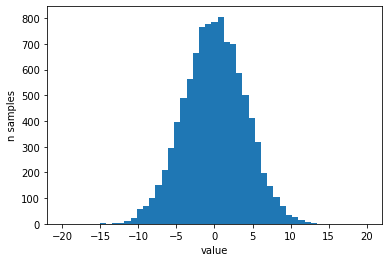

[6.51751019 3.33988925 1.37989958 ... 0.01155803 0.01172175 0.01182591]
[0.         2.82842712 2.30940108 ... 0.040004   0.040002   0.04      ]
mean  0.011825907096949233
median  0.022393023172157793


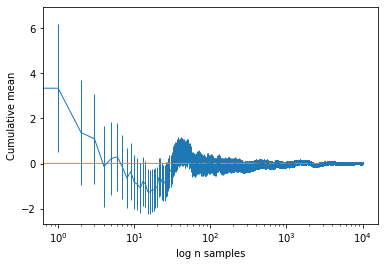

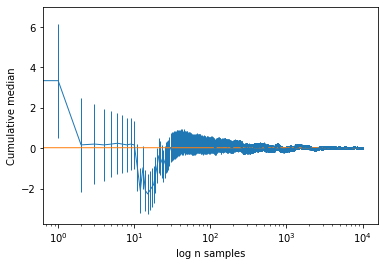

In [29]:
N = 10000
X = np.random.standard_normal(size=N) * 4
bins = np.linspace(-20, 20, 50)
plot_machine(X, N, bins)

### Pareto distribution

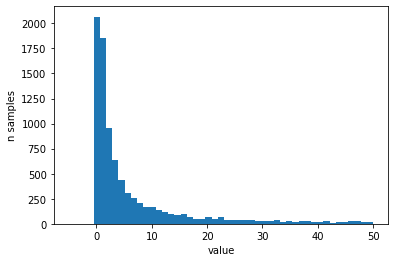

[2.68147779e+00 8.30460950e+00 2.74520097e+02 ... 3.96624069e+03
 3.96584413e+03 3.96544758e+03]
[0.         2.82842712 2.30940108 ... 0.040004   0.040002   0.04      ]
mean  3965.4475800789833
median  3.0615375379925647


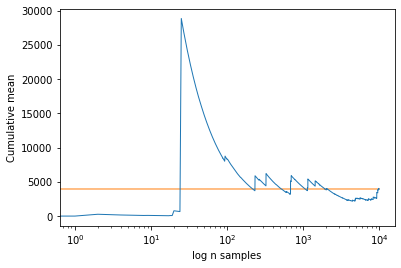

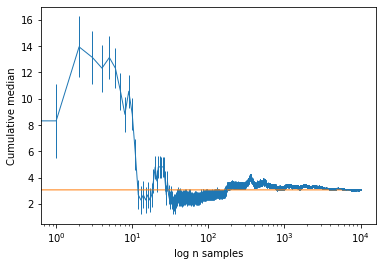

In [30]:
alfa = 0.5
N = 10000
X = np.random.pareto(alfa, size = N) #implicitly xm is 1
bins = np.linspace(-5, 50, 50)
plot_machine(X, N, bins)

### LogNormal distribution

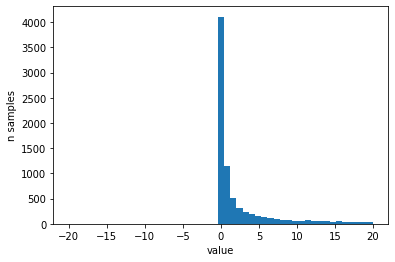

[   5.73314104    2.93132512    3.41459104 ... 2709.20456482 2708.93384734
 2708.66295777]
[0.         2.82842712 2.30940108 ... 0.040004   0.040002   0.04      ]
mean  2708.662957769883
median  0.946948211004179


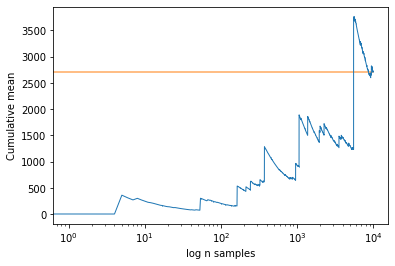

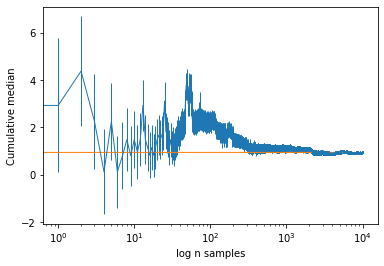

In [31]:
N = 10000
X = np.random.standard_normal(N) * 4 + 0   #if X ~ LogNormal then log(X) ~ Normal 
                                          #therefore exp(X) ~ Lognormal  as   log(X) ~ normal
X = np.exp(X)  #natural log
bins = np.linspace(-20, 20, 50)
plot_machine(X, N, bins)


Comparing the evolution of the cumulative average of the 3 distributions, we see the following:

1. The cumulative mean keeps increasing for both fat tailed distributions ie. pareto and log normal.
2. The cumulative median seems to converge for both fat tailed distributions when the number of samples increase
3. The cumulative mean and median converges for the normal gaussian to the same value 0






Now we use the data of we collected, for papir citations in 2009 

The above includes answers for points 1 through 12

Now, instead of looking at predefined distributions we will sample from paper citations from 2009

Number of papers which we extract citations counts from:  87881
mean of random bootstrapped sample of citations:  72.0468
median:  18.0


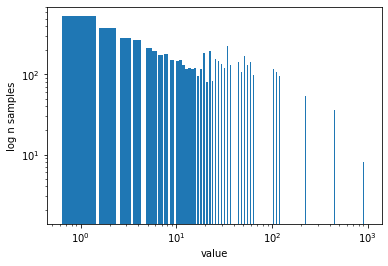

[23.         17.5        14.         ... 72.05921184 72.05390539
 72.0468    ]
[0.         2.82842712 2.30940108 ... 0.040004   0.040002   0.04      ]
mean  72.0468
median  18.0


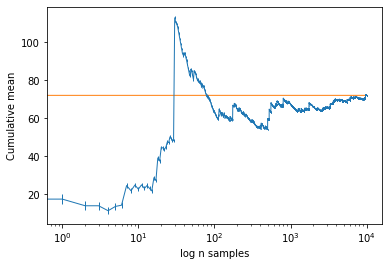

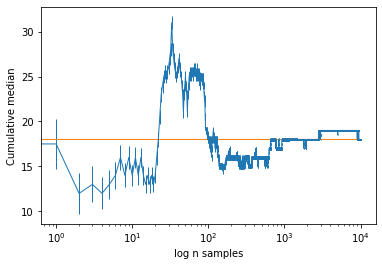

In [32]:
paperDF = pd.read_csv('paperDF.csv')
#{'paperId':[],'title':[], 'year':[], 'externalId':[], 'citationCount':[], 'fields':[], "authorIds":[]}

helper = paperDF["year"].to_numpy() 
mask2009 = helper == 2009
citationCountArray2009 = paperDF["citationCount"].to_numpy()[mask2009] #len = 195
x = citationCountArray2009

N = 10000
indices = np.random.randint(low=0, high=len(x), size = N)
random_sample = np.zeros((N,))
for i in range(N):
    random_sample[i] = citationCountArray2009[indices[i]]
    
print("Number of papers which we extract citations counts from: ", len(x))
print("mean of random bootstrapped sample of citations: ", np.mean(random_sample))
print("median: ", np.median(random_sample))

X = random_sample
bins = np.logspace(0, 3, 100)

plot_machine(X, N, bins, defined_width = False, log_y = True)

Interrestingly, plotting the histogram of the number of samples, shows a somewhat although not perfectly pareto distributed variable! The pareto distribution breaks apart for the around 100 citations count, but otherwise a straight line could quite well fit the curve of histogram!

Now we try to do the same but for only the first 200 papers, to see the effect of bootstrapping from a small sample

Number of papers which we extract citations counts from:  200
mean of random bootstrapped sample of citations:  81.9143
median:  22.0


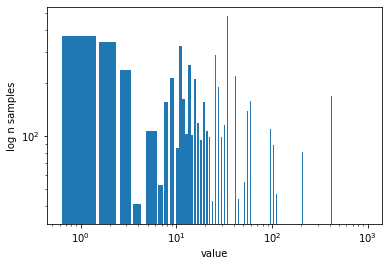

[102.          58.          40.66666667 ...  81.92658532  81.92159216
  81.9143    ]
[0.         2.82842712 2.30940108 ... 0.040004   0.040002   0.04      ]
mean  81.9143
median  22.0


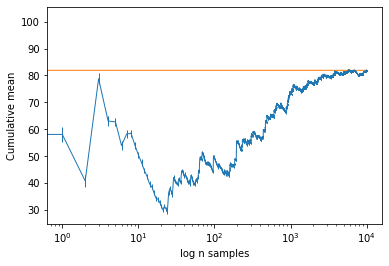

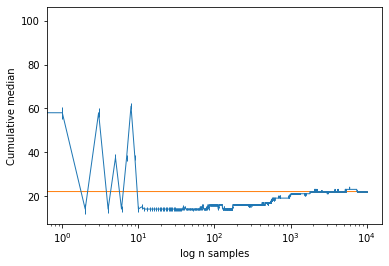

In [33]:
N = 10000
indices = np.random.randint(low=0, high=200, size = N)
random_sample = np.zeros((N,))
for i in range(N):
    random_sample[i] = citationCountArray2009[indices[i]]
    
print("Number of papers which we extract citations counts from: ", 200)
print("mean of random bootstrapped sample of citations: ", np.mean(random_sample))
print("median: ", np.median(random_sample))

X = random_sample
bins = np.logspace(0, 3, 100)

plot_machine(X, N, bins, defined_width = False, log_y = True)

1.  
The interresting thing is that while the Gaussian cumulative average converges on the same value, also when increasing the number of samples, the pareto or lognormal does not converge on the same average value.
What we see in action, is that the average continouly increases for the 2 later distributions, as their mean does not converge.
More numerically, rare values from the tail are sampled which pulls up the mean drastically, the more samples the more these rare values are sampled, and the higher they are. 

2. 
For all 3 distributions the median does actually converge towards a constant value.
This makes the median more meaningfull than the median, as it describes a property of the distribution for any number of samples. 
ie. we can say something general some pareto distributed phenomenon, by observing its median, while observing its mean simply tells us very little for what we might observe of that phenomenon if we took more samples.



3. For the total 88000 citation examples, we get more or less the same properties as if we sampled from a regular pareto distribution, when sampling 10.000 times.
However, if we only collect 200 samples and bootstrap from there to 10.000 samples we get the following interresting observation.
As we sample from a constant number of actual samples, even though the number of citations (probably) follows a pareto distribution, it does not result in a mean that increases with the number of samples. 
This is because we have sense frozen the distribution such that it cannot produce higher values than the highest we observed. 
This removes the property that was the divergence of the mean.


4. The main take home message could be, real data > bootstrapping from small samples
In short, the properties of a distribution is not the same when bootstrapping from a sample of set distribution, as when sampling from the distribution itself.
